In [1]:
!sudo mount -o discard,defaults /dev/sdb /sw-data

mount: /sw-data: /dev/sdb already mounted on /sw-data.


# Running iSax model to index time series and clustering the nodes with HDBSCAN

## SECTION 1: Extracting the perihelion files
- We extract the perihelion examples from the data set, with a cadence of 1 second and a time-chunk of 5 minute
- We collect its terminal nodes and their respective annotations (collections of datapoints)

## SECTION 2: Running the iSax pipeline 
- We  run the iSax pipeline saving input parameters to an output file
- We plot timeseries data at a node and  it's corresponding raw data

## SECTION 3: Applying HDB Scan
### _Essentially we cluster together similar terminal nodes (the collection of datapoints saved together into a single sequence)_
- Calculte the distance between some particularly nodes (5~50) and input these precomputed distances into HDB Scan
- We feed HDB Scan the annotations (collections of data) from each saved terminal node into HDB Scan
- Run TSNE to cluster similar terminal nodes
- We plot some figures with the clusteres nodes and projection.



In [2]:
# Native Python imports (packages that come installed natively with Python)
from collections import defaultdict
import glob
import datetime as dt
import sys
import os
import random

mod_dir = os.path.dirname(os.getcwd()).split('/')[:-1]
mod_dir.append('src')
data_module_directory = os.path.join('/', *mod_dir)
sys.path.append(data_module_directory)

# External packages
import hdbscan
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
# plt.style.use('ggplot')
import matplotlib.dates as mdates
# plt.style.use('ggplot')
import pandas as pd
from sklearn.manifold import TSNE
import seaborn as sns

import wandb

# # Native packages
import data.helper_funcs as hf
import model.isax_model as isax_model

In [3]:
# wandb.login() 

## SECTION 1: Extracting the perihelion files

In [5]:
min_cardinality = 8
max_cardinality = 32
isax_pipe = isax_model.iSaxPipeline(
    orbit_fname='psp_orbit.csv',
    catalog_fname='wind_master_catalog_2006_2022.txt',
    threshold=200,
    word_size=10,
    min_cardinality=min_cardinality,
    max_cardinality=max_cardinality,
    instrument = 'wind'
    # mu=0.,
    # std=2.5
)

In [6]:
isax_pipe.catalog.head()

,fname,B_mag_nan,BGSE_0_nan,BGSE_1_nan,BGSE_2_nan,B_mag_mean,B_mag_rms,B_mag_min,B_mag_max,BGSE_0_mean,...,BGSE_2_diff_min,BGSE_2_diff_max,average_freq,max_freq,min_freq,n_gaps,starttime_gaps,total_missing,coverage,bad
date,,,,,,,,,,,,,,,,,,,,,
2006-01-01,/2006/wi_h2_mfi_20060101_v05.cdf,0,0,0,0,10.661316,2.614027,1.326523,20.629436,3.854529,...,-2.517450,4.869592,0.092412,24.012,0.091,3,"[DatetimeIndex(['2006-01-01 06:57:59.383491', ...",66.884016,0.999226,False
2006-01-02,/2006/wi_h2_mfi_20060102_v05.cdf,0,0,0,0,5.424582,2.578532,0.023387,11.348069,1.028426,...,-1.662244,1.220974,0.092591,24.748,0.091,8,"[DatetimeIndex(['2006-01-02 00:41:28.369494', ...",169.187996,0.998042,False
2006-01-03,/2006/wi_h2_mfi_20060103_v05.cdf,0,0,0,0,4.204156,0.493157,1.925005,5.186341,-0.899078,...,-0.625929,0.848567,0.092680,92.092,0.047,4,"[DatetimeIndex(['2006-01-03 03:54:31.672498', ...",239.588010,0.997227,False
2006-01-04,/2006/wi_h2_mfi_20060104_v05.cdf,0,0,0,0,4.668325,0.255996,3.188930,5.582067,-2.442346,...,-1.012588,0.664107,0.092518,78.108,0.091,2,"[DatetimeIndex(['2006-01-04 04:09:55.960504', ...",97.703997,0.998869,False
2006-01-05,/2006/wi_h2_mfi_20060105_v05.cdf,0,0,0,0,5.124425,0.572812,2.987544,7.018934,-2.199037,...,-0.939403,0.931709,0.093082,158.700,0.091,10,"[DatetimeIndex(['2006-01-05 03:46:25.736499', ...",525.596002,0.993917,False


In [8]:
path = '/sw-data/wind/mfi_h2/'

#perihelion dates
wind_perihelion_dates = ['20181104','20181105','20181106','20181107','20181108',
                    '20190403','20190404','20190405','20190406','20190407',
                    '20190831',
                    '20190901','20190902','20190903','20190904']
wind_perihelion_files = ['wi_h2_mfi_' + i + '_v05.cdf' for i in wind_perihelion_dates]

#aphelion dates
wind_aphelion_dates = ['20191112','20191113','20191114','20191115','20191116',
                  '20191117','20191118','20191119']
wind_aphelion_files = ['wi_h2_mfi_' + j + '_v05.cdf' for j in wind_aphelion_dates]

In [29]:
isax_pipe.mu, isax_pipe.std

({'x': 0.2, 'y': 0.2, 'z': 0.2}, {'x': 3.4, 'y': 3.4, 'z': 3.4})

In [30]:
# isax_pipe.load_root(fname='isax_pipeline_run_2021_07_21.yaml')

In [12]:
aphelion_dates ='2019-01-20T00:00:00,2019-01-21T00:00:00,2019-06-18T00:00:00,2019-06-19T00:00:00,2019-11-15T00:00:00,2019-11-16T00:00:00'.split(',')
aphelion_dates = [dt.datetime.strptime(val, '%Y-%m-%dT%H:%M:%S') for val in aphelion_dates]

In [13]:
aphelion_dates

[datetime.datetime(2019, 1, 20, 0, 0),
 datetime.datetime(2019, 1, 21, 0, 0),
 datetime.datetime(2019, 6, 18, 0, 0),
 datetime.datetime(2019, 6, 19, 0, 0),
 datetime.datetime(2019, 11, 15, 0, 0),
 datetime.datetime(2019, 11, 16, 0, 0)]

In [14]:
perihelion_dates = '2018-11-06T00:00:00,2019-04-05T00:00:00,2019-09-02T00:00:00'.split(',')
perihelion_dates = [dt.datetime.strptime(val, '%Y-%m-%dT%H:%M:%S') for val in perihelion_dates]

## Aphelion Dates
2019-01-20T00:00:00

2019-01-21T00:00:00

2019-06-18T00:00:00

2019-06-19T00:00:00

2019-11-15T00:00:00

2019-11-16T00:00:00

### Perihelion

2018-11-06T00:00:00	

2019-04-05T00:00:00

2019-09-02T00:00:00

In [15]:
offset = dt.timedelta(days=3)
days_to_process = []
catalog_cut_aphelion = pd.DataFrame()
for date in aphelion_dates:
    st = date - offset
    et = date + offset
    cut = isax_pipe.catalog[st: et]
    catalog_cut_aphelion = pd.concat([catalog_cut_aphelion, cut])
    if cut.empty:
        continue
    date_str = date.strftime('%Y-%m-%d')
    cut.to_csv(f'wind_aphelion_{date_str}.txt', header=True, index=True)
    days_to_process.append(cut)
    

In [16]:
catalog_cut.to_csv(f'wind_aphelion_week_7.csv')
catalog_cut

,fname,B_mag_nan,BGSE_0_nan,BGSE_1_nan,BGSE_2_nan,B_mag_mean,B_mag_rms,B_mag_min,B_mag_max,BGSE_0_mean,...,BGSE_2_diff_min,BGSE_2_diff_max,average_freq,max_freq,min_freq,n_gaps,starttime_gaps,total_missing,coverage,bad
date,,,,,,,,,,,,,,,,,,,,,
2019-01-17,/2019/wi_h2_mfi_20190117_v05.cdf,0,0,0,0,6.726773,1.586152,0.351940,11.078515,2.778860,...,-1.019870,1.112547,0.092159,92.092,0.091,2,"[DatetimeIndex(['2019-01-17 04:05:43.683498', ...",117.667989,0.998638,False
2019-01-18,/2019/wi_h2_mfi_20190118_v05.cdf,0,0,0,0,4.296083,0.672103,1.627108,6.521035,2.434617,...,-0.618638,0.754725,0.092051,20.424,0.091,1,"[DatetimeIndex(['2019-01-18 14:50:50.423500'],...",20.423999,0.999764,False
2019-01-19,/2019/wi_h2_mfi_20190119_v05.cdf,0,0,0,0,3.267113,0.269939,1.209042,4.246387,1.245011,...,-3.220363,0.969899,0.092333,92.092,0.091,7,"[DatetimeIndex(['2019-01-19 01:34:50.419497', ...",281.244018,0.996745,False
2019-01-20,/2019/wi_h2_mfi_20190120_v05.cdf,0,0,0,0,3.176643,0.894835,0.283819,5.548726,0.858278,...,-0.840750,0.916629,0.092264,105.524,0.091,5,"[DatetimeIndex(['2019-01-20 02:54:05.941490', ...",220.524021,0.997448,False
2019-01-21,/2019/wi_h2_mfi_20190121_v05.cdf,0,0,0,0,2.962543,0.437255,0.762730,4.053241,2.301743,...,-0.348254,0.433809,0.092127,24.472,0.091,4,"[DatetimeIndex(['2019-01-21 07:34:29.471502', ...",86.203999,0.999002,False
2019-01-22,/2019/wi_h2_mfi_20190122_v05.cdf,0,0,0,0,4.407709,1.202040,0.123154,8.130323,1.695937,...,-0.696868,2.357113,0.092129,36.892,0.091,4,"[DatetimeIndex(['2019-01-22 02:55:50.724496', ...",92.552002,0.998929,False
2019-01-23,/2019/wi_h2_mfi_20190123_v05.cdf,0,0,0,0,7.162331,1.535797,0.227553,11.004822,-0.887042,...,-3.971327,2.560412,0.096200,3330.491,0.091,12,"[DatetimeIndex(['2019-01-23 04:32:46.638505', ...",3717.166983,0.956977,False
2019-01-18,/2019/wi_h2_mfi_20190118_v05.cdf,0,0,0,0,4.296083,0.672103,1.627108,6.521035,2.434617,...,-0.618638,0.754725,0.092051,20.424,0.091,1,"[DatetimeIndex(['2019-01-18 14:50:50.423500'],...",20.423999,0.999764,False
2019-01-19,/2019/wi_h2_mfi_20190119_v05.cdf,0,0,0,0,3.267113,0.269939,1.209042,4.246387,1.245011,...,-3.220363,0.969899,0.092333,92.092,0.091,7,"[DatetimeIndex(['2019-01-19 01:34:50.419497', ...",281.244018,0.996745,False


In [23]:
offset = dt.timedelta(days=8)
days_to_process = []
catalog_cut_perihelion = pd.DataFrame()
for date in perihelion_dates:
    st = date - offset
    et = date + offset
    cut = isax_pipe.catalog[st: et]
    catalog_cut_perihelion = pd.concat([catalog_cut_perihelion, cut])

    if cut.empty:
        continue
    date_str = date.strftime('%Y-%m-%d')
    cut.to_csv(f'perihelion_{date_str}.txt', header=True, index=True)
    days_to_process.append(cut)

In [24]:
catalog_cut.to_csv(f'wind_perihelion_week_7.csv')
catalog_cut

,fname,B_mag_nan,BGSE_0_nan,BGSE_1_nan,BGSE_2_nan,B_mag_mean,B_mag_rms,B_mag_min,B_mag_max,BGSE_0_mean,...,BGSE_2_diff_min,BGSE_2_diff_max,average_freq,max_freq,min_freq,n_gaps,starttime_gaps,total_missing,coverage,bad
date,,,,,,,,,,,,,,,,,,,,,
2018-10-29,/2018/wi_h2_mfi_20181029_v05.cdf,0,0,0,0,3.450611,0.696388,0.359068,5.434969,-0.913833,...,-1.162905,1.931078,0.092213,92.092,0.091,5,"[DatetimeIndex(['2018-10-29 05:21:39.466491', ...",173.604018,0.997991,False
2018-10-30,/2018/wi_h2_mfi_20181030_v05.cdf,0,0,0,0,3.904929,0.890785,0.444866,6.456642,0.270111,...,-0.690203,0.891095,0.092177,92.092,0.091,3,"[DatetimeIndex(['2018-10-30 04:31:28.257498', ...",129.167997,0.998505,False
2018-10-31,/2018/wi_h2_mfi_20181031_v05.cdf,0,0,0,0,4.042006,1.174181,0.068274,6.279197,-1.788517,...,-0.906784,2.329609,0.092377,92.092,0.091,7,"[DatetimeIndex(['2018-10-31 06:05:43.448499', ...",328.992000,0.996192,False
2018-11-01,/2018/wi_h2_mfi_20181101_v05.cdf,0,0,0,0,3.662544,1.265554,0.011462,7.192777,-0.887758,...,-2.182147,2.641833,0.092869,92.092,0.091,20,"[DatetimeIndex(['2018-11-01 05:13:41.840496', ...",609.499961,0.992946,False
2018-11-02,/2018/wi_h2_mfi_20181102_v05.cdf,0,0,0,0,3.615444,0.799638,0.108121,6.370982,0.083090,...,-2.218716,1.056576,0.092193,92.092,0.091,3,"[DatetimeIndex(['2018-11-02 07:15:11.594499', ...",150.511998,0.998258,False
2018-11-03,/2018/wi_h2_mfi_20181103_v05.cdf,0,0,0,0,4.348610,0.786468,0.210461,6.215685,-0.503680,...,-2.199290,0.731467,0.092332,99.636,0.091,4,"[DatetimeIndex(['2018-11-03 04:00:47.971503', ...",300.287991,0.996524,False
2018-11-04,/2018/wi_h2_mfi_20181104_v05.cdf,0,0,0,0,6.317763,2.670831,0.181223,16.501432,-1.730929,...,-3.399530,5.087395,0.092239,84.088,0.091,7,"[DatetimeIndex(['2018-11-04 00:20:47.579493', ...",214.268020,0.997520,False
2018-11-05,/2018/wi_h2_mfi_20181105_v05.cdf,0,0,0,0,6.386021,2.531478,0.075624,13.978662,-3.057341,...,-2.036758,2.234092,0.092095,37.076,0.091,2,"[DatetimeIndex(['2018-11-05 03:54:22.577496', ...",56.395993,0.999347,False
2018-11-06,/2018/wi_h2_mfi_20181106_v05.cdf,0,0,0,0,3.588377,0.799127,0.014500,5.631015,-1.910709,...,-0.514058,0.782307,0.092240,98.900,0.091,6,"[DatetimeIndex(['2018-11-06 00:36:23.398497', ...",194.395999,0.997750,False


In [14]:
days_to_process

[                                                           fname  B_mag_nnan  \
 date                                                                           
 2018-11-04 00:00:00  /2018/psp_fld_l2_mag_rtn_2018110400_v01.cdf           0   
 2018-11-04 06:00:00  /2018/psp_fld_l2_mag_rtn_2018110406_v01.cdf           0   
 2018-11-04 12:00:00  /2018/psp_fld_l2_mag_rtn_2018110412_v01.cdf           0   
 2018-11-04 18:00:00  /2018/psp_fld_l2_mag_rtn_2018110418_v01.cdf           0   
 2018-11-05 00:00:00  /2018/psp_fld_l2_mag_rtn_2018110500_v01.cdf           0   
 2018-11-05 06:00:00  /2018/psp_fld_l2_mag_rtn_2018110506_v01.cdf           0   
 2018-11-05 12:00:00  /2018/psp_fld_l2_mag_rtn_2018110512_v01.cdf           0   
 2018-11-05 18:00:00  /2018/psp_fld_l2_mag_rtn_2018110518_v01.cdf           0   
 2018-11-06 00:00:00  /2018/psp_fld_l2_mag_rtn_2018110600_v01.cdf           0   
 2018-11-06 06:00:00  /2018/psp_fld_l2_mag_rtn_2018110606_v01.cdf           0   
 2018-11-06 12:00:00  /2018/

In [13]:
len(days_to_process)

3

In [15]:
days_to_process[1]['fname']

date
2019-04-04 00:00:00    /2019/psp_fld_l2_mag_rtn_2019040400_v01.cdf
2019-04-04 06:00:00    /2019/psp_fld_l2_mag_rtn_2019040406_v01.cdf
2019-04-04 12:00:00    /2019/psp_fld_l2_mag_rtn_2019040412_v01.cdf
2019-04-04 18:00:00    /2019/psp_fld_l2_mag_rtn_2019040418_v01.cdf
2019-04-05 00:00:00    /2019/psp_fld_l2_mag_rtn_2019040500_v01.cdf
2019-04-05 06:00:00    /2019/psp_fld_l2_mag_rtn_2019040506_v01.cdf
2019-04-05 12:00:00    /2019/psp_fld_l2_mag_rtn_2019040512_v01.cdf
2019-04-05 18:00:00    /2019/psp_fld_l2_mag_rtn_2019040518_v01.cdf
2019-04-06 00:00:00    /2019/psp_fld_l2_mag_rtn_2019040600_v01.cdf
Name: fname, dtype: object

In [16]:
convert = lambda val: hf.fname_to_datetime(val, fmt='%Y%m%d%H')
dates = isax_pipe.catalog['fname'].apply(convert)
isax_pipe.catalog.index = pd.DatetimeIndex(dates)


In [17]:
isax_pipe.catalog.index

DatetimeIndex(['2018-10-02 00:00:00', '2018-10-02 06:00:00',
               '2018-10-02 12:00:00', '2018-10-03 00:00:00',
               '2018-10-03 06:00:00', '2018-10-03 12:00:00',
               '2018-10-03 18:00:00', '2018-10-04 00:00:00',
               '2018-10-04 06:00:00', '2018-10-04 12:00:00',
               ...
               '2020-12-29 12:00:00', '2020-12-29 18:00:00',
               '2020-12-30 00:00:00', '2020-12-30 06:00:00',
               '2020-12-30 12:00:00', '2020-12-30 18:00:00',
               '2020-12-31 00:00:00', '2020-12-31 06:00:00',
               '2020-12-31 12:00:00', '2020-12-31 18:00:00'],
              dtype='datetime64[ns]', name='fname', length=2470, freq=None)

In [18]:
aphelion = dt.datetime(2019, 1, 20)
perihelion = dt.datetime(2019, 9, 2)
search_window = dt.timedelta(days=60)
search_time = aphelion


In [19]:
perihelion_cut = isax_pipe.catalog[search_time-search_window:search_time+search_window]

In [20]:
flist = list(perihelion_cut['fname'][:50])

In [21]:
#flist = list(perihelion_cut['fname'].values)
flist=flist[:5]

In [22]:
flist

['/2018/psp_fld_l2_mag_rtn_2018112100_v01.cdf',
 '/2018/psp_fld_l2_mag_rtn_2018112106_v01.cdf',
 '/2018/psp_fld_l2_mag_rtn_2018112112_v01.cdf',
 '/2018/psp_fld_l2_mag_rtn_2018112118_v01.cdf',
 '/2018/psp_fld_l2_mag_rtn_2018112200_v01.cdf']

In [23]:
len(flist)

5

## SECTION 2: Running the iSax pipeline 

In [24]:
isax_pipe.run_pipeline(
        flist=flist,
        cadence=dt.timedelta(seconds=1),
        chunk_size=dt.timedelta(seconds=300),
        rads_norm=True,
        smooth=True,
        smooth_window=2,
        detrend=True,
        detrend_window=1800
)

Reading Files: 100%|██████████| 5/5 [00:01<00:00,  2.84it/s]
INFO [isax_model:get_time_chunks:371] Smoothing, interpolating, and chunking the time series..
INFO [isax_model:get_time_chunks:409] Finished the timechunking steps...
Total duration: 4.716 seconds
------------------------------------------------------------
INFO [isax_model:build_annotations:583] Total duration: 0.015 seconds
------------------------------------------------------------
INFO [isax_model:generate_nodes:617] Total duration: 3.731 seconds
------------------------------------------------------------
INFO [isax_model:generate_nodes:617] Total duration: 3.868 seconds
------------------------------------------------------------
INFO [isax_model:generate_nodes:617] Total duration: 3.889 seconds
------------------------------------------------------------
INFO [isax_model:run_pipeline:791] Finished processing all files...
Total duration: 10.390 seconds
------------------------------------------------------------


In [25]:
isax_pipe.sw_forest['x'].forest[0].isax.std

3.4

In [26]:
stats = isax_pipe.mag_df.describe()

In [27]:
stats

,B_mag,BRTN_0,BRTN_1,BRTN_2
count,247192.000000,247192.000000,247192.000000,247192.000000
mean,4.078993,1.585071,-2.011285,-0.734813
std,1.452307,1.220180,3.271144,2.589790
min,0.008476,-2.508369,-9.038538,-9.365549
25%,2.942504,0.888720,-4.739782,-2.445899
50%,3.961323,1.925524,-2.491590,-0.493717
75%,5.140961,2.485013,0.312067,0.988430
max,9.042241,3.559905,6.632874,8.200212


In [28]:
cols = [val for val in isax_pipe.mag_df.columns if 'mag' not in val]

In [29]:
cols

['BRTN_0', 'BRTN_1', 'BRTN_2']

In [30]:
stats.loc['mean', cols].mean()

-0.38700894514719647

In [31]:
stats.loc['std']

B_mag     1.452307
BRTN_0    1.220180
BRTN_1    3.271144
BRTN_2    2.589790
Name: std, dtype: float64

In [32]:
stats.loc['std', cols].mean()

2.3603712717692056

In [33]:
node_level = 16
isax_pipe.get_nodes_at_level(component='x', node_level=node_level)
nodes_at_level = isax_pipe.nodes_at_level
node_sizes = []
for node in isax_pipe.nodes_at_level['x'][16]:
    node_sizes.append(len(node.get_annotations()))
print(np.max(node_sizes), np.argmax(node_sizes))

node_sizes = pd.Series(node_sizes)
node_sizes.sort_values(ascending=False, inplace=True)
print(node_sizes[:10])

101 12
12     101
40      18
19       7
33       6
1        6
137      5
115      5
14       4
60       4
71       3
dtype: int64


In [34]:
print(np.sum(node_sizes))

360


In [34]:
node.nb_sequences

1

In [35]:
print(isax_pipe.nodes_at_level['x'][16][12].get_annotations())

                                            File  Component  \
0    /2018/psp_fld_l2_mag_rtn_2018112200_v01.cdf          0   
1    /2018/psp_fld_l2_mag_rtn_2018112200_v01.cdf          0   
2    /2018/psp_fld_l2_mag_rtn_2018112200_v01.cdf          0   
3    /2018/psp_fld_l2_mag_rtn_2018112200_v01.cdf          0   
4    /2018/psp_fld_l2_mag_rtn_2018112200_v01.cdf          0   
..                                           ...        ...   
96   /2018/psp_fld_l2_mag_rtn_2018112200_v01.cdf          0   
97   /2018/psp_fld_l2_mag_rtn_2018112200_v01.cdf          0   
98   /2018/psp_fld_l2_mag_rtn_2018112200_v01.cdf          0   
99   /2018/psp_fld_l2_mag_rtn_2018112200_v01.cdf          0   
100  /2018/psp_fld_l2_mag_rtn_2018112200_v01.cdf          0   

                            t0                         t1  chunk_num  \
0   2018-11-21 01:00:01.277474 2018-11-21 01:05:00.277474         12   
1   2018-11-21 01:15:01.277474 2018-11-21 01:20:00.277474         15   
2   2018-11-21 01:20:01.277

# Define functions to plot

In [16]:
def plot_bkpts(ax, isax_pipe, component, cardinality=None):
    """Function that plots the breakpoints on a given axis

    Parameters
    ----------
    ax : matplotlib.axes
        Axes to plot the breakpoints
    isax_pipe : isax_model.iSaxPipeline
        iSax pipeline object with isax definition
    component : str
        Magnetic field component to choose the right tree
    cardinality : int
        cardinality of breakpoints
    """
    if cardinality is None:
        cardinality = isax_pipe.min_cardinality
    bkpt = isax_pipe.sw_forest[component].forest[0].isax._card_to_bkpt(cardinality)
    [ax.axhline(b, ls='--', c='r') for b in bkpt]
    # [ax.text(x=310, y=b-0.5, s=str(i)) for i, b in enumerate(bkpt)]


In [17]:
def plot_node_curves(ax, nodes, ntimeseries=5, rand_subset=None, as_area=False, percentiles=[10,50,90], plot_median=True, **kwargs):
    """Some code for plotting timeseries data at a node and 
    it's corresponding raw data

    Parameters
    ----------
    ax : matplotlib.axes
        Axes to plot the breakpoints
    nodes: list
        List of nodes to plot
    ntimeseries : int
        Number of time series to plot. Time series are randomly chosen. Overriden by rand_subset
        If None, plots all series.
    rand_subset : np.array
        subset of lines to plot. If provided, it overrides ntimeseries
    as_area: bool
        Flag that plots an area instead of the individual curves
    percentiles: list
        list of three numbers to be used as percentiles, the middle one should be 50, because we assume it is the median
    plot_median: bool
        Flag that plots the median
    **kwargs: Line2D or Fill properties
        Properties passed to the plottin of the time-series or the area

    Returns
    -------
    legend: pd.pd.DataFrame
        Dataframe with the starting date for each time-series to be used as legend        
    """
    
    legend = pd.DataFrame()
    B = None
    legend = None

    for node in nodes:
        if rand_subset is None or rand_subset.shape[0]>node.nb_sequences:
            if ntimeseries is None:
                ntimeseries = node.nb_sequences
            rand_subset = np.random.choice(node.nb_sequences, np.min([ntimeseries, node.nb_sequences]))
        
        data = node.get_annotations()
        data = data.iloc[rand_subset].copy()
        data.sort_index(ascending=True, inplace=True)

        if as_area:
            if B is None:
                B = isax_pipe.interp_mag_seq[data['chunk_num'].values, :, data['Component'].values]
            else:
                B = np.concatenate((B, isax_pipe.interp_mag_seq[data['chunk_num'].values, :, data['Component'].values]))
            t = isax_pipe.interp_time_seq[data['chunk_num'].values, :][0, :, 0]
            time_step = (t[1] - t[0])/np.timedelta64(1, 's')
            time_steps = [time_step * i for i in range(t.shape[0])]        

        else:
            for j, (i, row) in enumerate(data.iterrows()):
                chunk = row['chunk_num']
                component = row['Component']
                B = isax_pipe.interp_mag_seq[chunk][:, component]
                t = isax_pipe.interp_time_seq[chunk][:, 0].flatten()
                time_step = (t[1] - t[0])/np.timedelta64(1, 's')
                time_steps = [time_step * i for i in range(t.shape[0])]
                ax.plot(time_steps, B, **kwargs)

            if legend is None:
                legend = pd.DataFrame(index = data['t0'].values)
            else:
                legend = legend.append(pd.DataFrame(index = data['t0'].values))

    if as_area:
        print(B.shape)
        percentiles = np.percentile(B, percentiles, axis=0)
        print(percentiles.shape)
        ax.fill_between(time_steps, percentiles[0,:], percentiles[2,:], **kwargs)
        if plot_median:
            ax.plot(time_steps, percentiles[1,:], color='k')            
    
    return legend

In [38]:
# len(nodes_at_level['x'][16][[1,20]])
# isax_pipe.nodes_at_level['x'][16][20]

# node_index = [20,55]

# [isax_pipe.nodes_at_level['x'][16][i] for i in node_index]

## Plot curves using functions

(3, 300)
(3, 300)
(3, 300)
(3, 300)
(3, 300)
(3, 300)
(3, 300)
(3, 300)


""
2018-11-21 14:20:01.277474


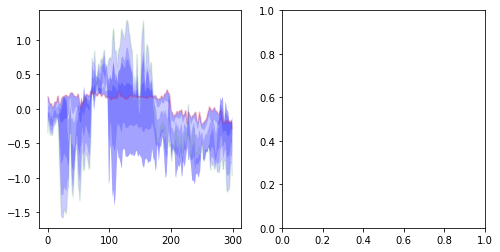

In [39]:
component = 'x'

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

node_index = [20,100]
nodes = [isax_pipe.nodes_at_level['x'][16][i] for i in node_index]

rand_subset = np.random.choice(node.nb_sequences, 10)
legend = plot_node_curves(ax[0], nodes, ntimeseries=None, as_area=True, plot_median=False, percentiles=[100,50,0], alpha=0.2, color='b', ec='None')
plot_node_curves(ax[0], nodes, ntimeseries=None, as_area=True, plot_median=False, percentiles=[75,50,25], alpha=0.2, color='b', ec='None')
plot_node_curves(ax[0], nodes, ntimeseries=None, as_area=True, plot_median=False, alpha=0.2, color='b', ec='None')
plot_node_curves(ax[0], nodes, ntimeseries=None, as_area=True, plot_median=False, percentiles=[60,50,40], alpha=0.2, color='b', ec='None')


node_index = [20]
nodes = [isax_pipe.nodes_at_level['x'][16][i] for i in node_index]
plot_node_curves(ax[0], nodes, ntimeseries=None, alpha=0.1, color='r')

node_index = [100]
nodes = [isax_pipe.nodes_at_level['x'][16][i] for i in node_index]
plot_node_curves(ax[0], nodes, ntimeseries=None, alpha=0.1, color='g')




# plot_bkpts(ax[0], isax_pipe, component)
# plot_bkpts(ax[1], isax_pipe, component, cardinality=16)

# ax[0].legend(legend.index.strftime('%Y-%m-%d %H:%M'))

In [40]:
legend.index.strftime('%Y-%m-%d %H:%M')
# legend

AttributeError: 'NoneType' object has no attribute 'index'

In [18]:
def plot_node(isax_pipe, component, node_level, ntimeseries, node_num, nsamples=0, alpha=0.5, plot_bkt=False):
    """Some code for plotting timeseries data at a node and 
    it's corresponding raw data

    Parameters
    ----------
    isax_pipe : bool
        [description]
    node_level : [type]
        [description]
    node_num : [type]
        [description]
    """
    isax_pipe.get_nodes_at_level(component=component, node_level=node_level)
    isax_pipe.get_node_info(component=component, node_level=node_level, node_num=node_num)
    # isax_pipe.get_node_info(node_level=node_level, node_num=node_num) 
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
    data = isax_pipe.node_info[component][node_level][node_num]['annotation']
    # data.sort_index(ascending=True, inplace=True)
    #colors = plt.get_cmap('tab10')
    colors = colours(len(data)) 
    if nsamples !=0:
        rand_subset = np.random.randint(data.shape[0], size=nsamples)
        data = data.iloc[rand_subset].copy()
        data.sort_index(ascending=True, inplace=True)
    
    # Get breakpoints for cardinality
    bkpt = isax_pipe.sw_forest[component].forest[0].isax._card_to_bkpt(isax_pipe.min_cardinality)
    if plot_bkt:
        [ax[0].axhline(b, ls='--', c='r') for b in bkpt]
        [ax[0].text(x=310, y=b-0.5, s=str(i)) for i, b in enumerate(bkpt)]

    for j, (i, row) in enumerate(data.iterrows()):
        chunk = row['chunk_num']
        component = row['Component']
        node_name = row['Node Name']
        st, et = row['t0'], row['t1']
        # print(i, st, et)
        B = isax_pipe.interp_mag_seq[chunk][:, component]
        t = isax_pipe.interp_time_seq[chunk][:, 0].flatten()
        time_step = (t[1] - t[0])/np.timedelta64(1, 's')
        time_steps = [time_step * i for i in range(t.shape[0])]
        ax[0].plot(time_steps, B, c='k', alpha=alpha)
       
        delta = dt.timedelta(minutes=5)
        dt_raw = (isax_pipe.mag_df[st-delta:et+delta].index - isax_pipe.mag_df[st-delta:et+delta].index[0]).total_seconds()
        ax[1].plot(
            dt_raw,
            isax_pipe.mag_df[st-delta:et+delta][f'BRTN_{component}'],
            lw=0.5,
            c=colors[i],
            label=f"{(st-delta).strftime('%Y-%m-%d %H:%M:%S')}"
        )
        if j == 0:
            ax[1].axvspan(
                time_steps[0]+delta.seconds, delta.seconds+time_steps[-1],
                color='k',
                alpha=0.1,
                label='similar structure'
            )
    for a in ax:
        a.set_xlabel('Time Elapsed [seconds]')
        # a.set_ylim(-3, 5)
    ax[0].axhline(0, ls='-', c='r', lw=1)
    ax[1].axhline(0, ls='-', c='r', lw=1)
    ax[0].set_xlim(0, 330)
    ax[0].set_ylim(-5,5)
    ax[0].set_ylabel('Magnetic Field Component [nT]')
    leg = ax[1].legend(bbox_to_anchor=(1.04,1), loc="upper left", edgecolor='k', fontsize=9, markerscale=6)
    for line in leg.get_lines():
        line.set_linewidth(1.0)
    fig.suptitle(f'Node Name\n{node_name}, N={ntimeseries}')
    return fig

def colours(N):
    """
    creates a list of random hex colours Parameters:
    -----------
    N: int
        the lenght of the array or list used for 
        plotting 
    """
    chars = '0123456789ABCDEF'
    col = ['#'+''.join(random.sample(chars,6)) for i in range(N)]
    return col


In [41]:

node_level = 16
alpha=0.8
component = 'x'
pdf = PdfPages('aphelion_nodes.pdf')
for idx, count in zip(node_sizes.index[:200], node_sizes[:200]):

    fig = plot_node(
        isax_pipe,
        component, 
        node_level=node_level,
        ntimeseries=count,
        node_num=idx,
        nsamples=10,
        alpha=alpha,
        plot_bkt=True
    )
    pdf.savefig(
        fig,
        dpi=150,
        bbox_inches='tight'    
    )
    plt.close(fig)
pdf.close()

NameError: name 'plot_node' is not defined

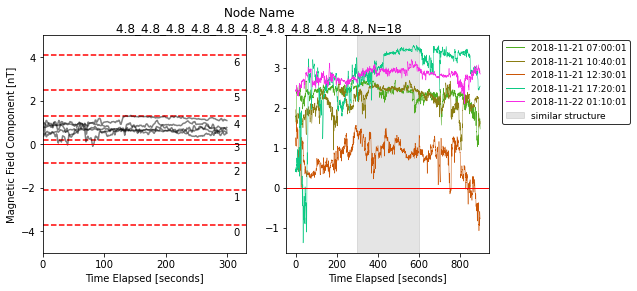

In [ ]:
node_level = 16
node_num=40
alpha=0.5
fig = plot_node(
    isax_pipe,
    component,
    node_level=node_level,
    ntimeseries=node_sizes.loc[node_num],
    node_num=node_num,
    nsamples=5,
    alpha=alpha,
    plot_bkt=True
)


In [ ]:
fig.savefig(
    f'cool_isax_test_files_node_{node_num}_lvl_{node_level}_aphelion_5min_offset.jpg',
    format='jpg',
    dpi=200,
    bbox_inches='tight'
)

## SECTION 3: Applying HDB Scan

## Clustering the nodes with HDBScan

In [19]:
idx = node_sizes.index[(node_sizes > 5) & (node_sizes < 50)]

In [43]:
node_sizes.index[40]

108

In [44]:
idx

Int64Index([40, 19, 33, 1], dtype='int64')

In [20]:
node_array = np.array(isax_pipe.nodes_at_level['x'][16])
nodes_at_level = isax_pipe.nodes_at_level['x'][16]

In [46]:
len(nodes_at_level)

182

In [47]:
nodes_at_level[1]

TerminalNode('/[[0 4]\n [0 4]\n [0 4]\n [0 4]\n [0 4]\n [0 4]\n [0 4]\n [0 4]\n [0 4]\n [0 4]]/[[3 8]\n [3 8]\n [3 8]\n [3 8]\n [4 8]\n [4 8]\n [4 8]\n [4 8]\n [4 8]\n [4 8]]', annotations=                                          File  Component  \
0  /2018/psp_fld_l2_mag_rtn_2018112200_v01.cdf          0   
1  /2018/psp_fld_l2_mag_rtn_2018112200_v01.cdf          0   
2  /2018/psp_fld_l2_mag_rtn_2018112200_v01.cdf          0   
3  /2018/psp_fld_l2_mag_rtn_2018112200_v01.cdf          0   
4  /2018/psp_fld_l2_mag_rtn_2018112200_v01.cdf          0   
5  /2018/psp_fld_l2_mag_rtn_2018112200_v01.cdf          0   

                          t0                         t1  chunk_num  \
0 2018-11-21 00:05:01.277474 2018-11-21 00:10:00.277474          1   
1 2018-11-21 07:55:01.277474 2018-11-21 08:00:00.277474         95   
2 2018-11-21 18:00:01.277474 2018-11-21 18:05:00.277474        216   
3 2018-11-21 22:30:01.277474 2018-11-21 22:35:00.277474        270   
4 2018-11-22 02:25:01.277474 2018

In [21]:
distance_matrix = np.zeros((len(nodes_at_level),len(nodes_at_level)))

for i in range(0,len(nodes_at_level)-1):
    for j in range(i+1,len(nodes_at_level)):
        dis = nodes_at_level[i].get_min_max_distance(nodes_at_level[j])
        distance_matrix[i,j] = dis[3]
        distance_matrix[j,i] = dis[3]      

In [49]:
# hdbscan.HDBSCAN?

(array([1.820e+02, 0.000e+00, 1.154e+03, 1.888e+03, 7.386e+03, 6.300e+03,
        4.600e+03, 3.436e+03, 2.816e+03, 2.246e+03, 1.228e+03, 8.560e+02,
        4.400e+02, 2.780e+02, 1.500e+02, 1.040e+02, 4.200e+01, 6.000e+00,
        8.000e+00, 4.000e+00]),
 array([0.        , 0.46596097, 0.93192194, 1.39788291, 1.86384387,
        2.32980484, 2.79576581, 3.26172678, 3.72768775, 4.19364872,
        4.65960968, 5.12557065, 5.59153162, 6.05749259, 6.52345356,
        6.98941453, 7.45537549, 7.92133646, 8.38729743, 8.8532584 ,
        9.31921937]),
 <BarContainer object of 20 artists>)

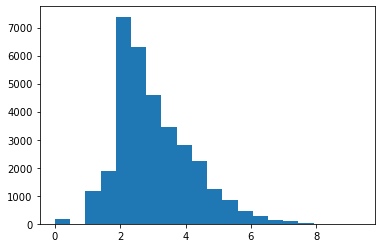

In [50]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.hist(distance_matrix.flatten(), bins=20)

In [22]:
clusterer = hdbscan.HDBSCAN(metric='precomputed', min_cluster_size=10, alpha=0.5)
clusterer.fit(distance_matrix)

HDBSCAN(alpha=0.5, metric='precomputed', min_cluster_size=10)

Text(0, 0.5, 'Number of nodes')

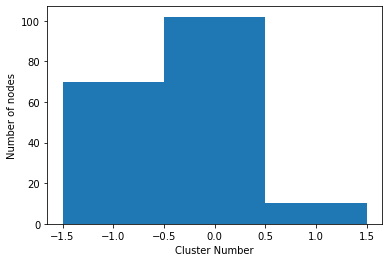

In [52]:
plt.hist(clusterer.labels_,bins=np.arange(np.min(clusterer.labels_), np.max(clusterer.labels_)+2)-0.5)
plt.xlabel('Cluster Number')
plt.ylabel('Number of nodes')

In [23]:
clusterer.labels_ 

array([-1,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1, -1,  0, -1,  0,  0,  0,
       -1, -1,  0,  0, -1,  0,  0, -1, -1,  0,  0, -1,  0, -1,  0, -1, -1,
        0,  0,  0,  0, -1, -1, -1,  0,  0,  0,  1,  1,  0,  0,  0,  0, -1,
        0,  0,  0,  0,  0, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1,  0,  0,  0, -1, -1,  0, -1,  0,  0,  0, -1, -1,  0, -1,  0,
       -1,  0, -1,  0,  0,  0, -1,  0, -1, -1, -1,  0,  0,  0,  1, -1, -1,
       -1, -1,  0,  0,  0, -1, -1,  0, -1,  0, -1,  0,  1,  0,  1, -1, -1,
        1,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  1,
       -1, -1,  0,  0, -1, -1, -1, -1, -1,  1, -1, -1, -1,  0,  0, -1, -1,
        0, -1,  0,  0,  0,  0,  0, -1, -1,  0,  0,  1])

In [54]:
clusterer.labels_.min()

-1

In [55]:
#node_sizes.index[0]
node_sizes

12     101
40      18
19       7
33       6
1        6
      ... 
76       1
77       1
78       1
80       1
181      1
Length: 182, dtype: int64

In [56]:
nodes_at_level[40]

TerminalNode('/[[0 4]\n [0 4]\n [0 4]\n [0 4]\n [0 4]\n [0 4]\n [0 4]\n [0 4]\n [0 4]\n [0 4]]/[[4 8]\n [4 8]\n [4 8]\n [4 8]\n [4 8]\n [4 8]\n [4 8]\n [4 8]\n [4 8]\n [4 8]]', annotations=                                           File  Component  \
0   /2018/psp_fld_l2_mag_rtn_2018112200_v01.cdf          0   
1   /2018/psp_fld_l2_mag_rtn_2018112200_v01.cdf          0   
2   /2018/psp_fld_l2_mag_rtn_2018112200_v01.cdf          0   
3   /2018/psp_fld_l2_mag_rtn_2018112200_v01.cdf          0   
4   /2018/psp_fld_l2_mag_rtn_2018112200_v01.cdf          0   
5   /2018/psp_fld_l2_mag_rtn_2018112200_v01.cdf          0   
6   /2018/psp_fld_l2_mag_rtn_2018112200_v01.cdf          0   
7   /2018/psp_fld_l2_mag_rtn_2018112200_v01.cdf          0   
8   /2018/psp_fld_l2_mag_rtn_2018112200_v01.cdf          0   
9   /2018/psp_fld_l2_mag_rtn_2018112200_v01.cdf          0   
10  /2018/psp_fld_l2_mag_rtn_2018112200_v01.cdf          0   
11  /2018/psp_fld_l2_mag_rtn_2018112200_v01.cdf          0   
12  /

In [57]:
isax_pipe.nodes_at_level['x'][16]

[TerminalNode('/[[0 4]\n [0 4]\n [0 4]\n [0 4]\n [0 4]\n [0 4]\n [0 4]\n [0 4]\n [0 4]\n [0 4]]/[[2 8]\n [2 8]\n [3 8]\n [2 8]\n [2 8]\n [2 8]\n [3 8]\n [3 8]\n [2 8]\n [2 8]]', annotations=                                          File  Component  \
 0  /2018/psp_fld_l2_mag_rtn_2018112200_v01.cdf          0   
 
                           t0                         t1  chunk_num  \
 0 2018-11-21 00:00:01.277474 2018-11-21 00:05:00.277474          0   
 
                                  Node Name  
 0  2.8_2.8_3.8_2.8_2.8_2.8_3.8_3.8_2.8_2.8  , bkpt_max=array([], dtype=float64), bkpt_min=array([], dtype=float64), cardinality=array([8, 8, 8, 8, 8, 8, 8, 8, 8, 8]), iSAX_word=array([[2, 8],
        [2, 8],
        [3, 8],
        [2, 8],
        [2, 8],
        [2, 8],
        [3, 8],
        [3, 8],
        [2, 8],
        [2, 8]]), iSAX_word_small='2.8_2.8_3.8_2.8_2.8_2.8_3.8_3.8_2.8_2.8', id=33, key_nodes={}, level=1, mean=array([-1.60753894, -1.02656603, -0.6518634 , -0.8838963 , -1.

In [58]:
#isax_pipe.nodes_at_level['x'][16][40].annotations['chunk_num'] 
#isax_pipe.nodes_at_level['x'][16][node_sizes.index[1]].annotations['chunk_num']
#nodes_at_level = isax_pipe.nodes_at_level['x'][16]
nodes_at_level[node_sizes.index[91]].annotations#['chunk_num'] #index=1 means node 40


,File,Component,t0,t1,chunk_num,Node Name
0,/2018/psp_fld_l2_mag_rtn_2018112200_v01.cdf,0,2018-11-21 22:50:01.277474,2018-11-21 22:55:00.277474,274,4.8_4.8_4.8_4.8_3.8_4.8_3.8_4.8_4.8_4.8


In [59]:
clusterer.labels_.max()

1

In [60]:
nodes_at_level = isax_pipe.nodes_at_level['x'][16]
cluster=np.where(clusterer.labels_ == 0)
print(cluster)
nodes_at_level[node_sizes.index[cluster[0][2]]].annotations['File'][0]
print(len(nodes_at_level[node_sizes.index[cluster[0][2]]].annotations['File']))

(array([  1,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
        15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  29,  31,
        32,  33,  36,  37,  39,  40,  43,  44,  46,  48,  51,  52,  53,
        54,  58,  59,  60,  63,  64,  65,  66,  68,  69,  70,  71,  72,
        87,  88,  89,  92,  94,  95,  96,  99, 101, 103, 105, 106, 107,
       109, 113, 114, 115, 121, 122, 123, 126, 128, 130, 132, 137, 138,
       139, 140, 141, 142, 143, 144, 146, 147, 148, 149, 150, 151, 155,
       156, 166, 167, 170, 172, 173, 174, 175, 176, 179, 180]),)
6


In [61]:
clusterer.labels_

array([-1,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1, -1,  0, -1,  0,  0,  0,
       -1, -1,  0,  0, -1,  0,  0, -1, -1,  0,  0, -1,  0, -1,  0, -1, -1,
        0,  0,  0,  0, -1, -1, -1,  0,  0,  0,  1,  1,  0,  0,  0,  0, -1,
        0,  0,  0,  0,  0, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1,  0,  0,  0, -1, -1,  0, -1,  0,  0,  0, -1, -1,  0, -1,  0,
       -1,  0, -1,  0,  0,  0, -1,  0, -1, -1, -1,  0,  0,  0,  1, -1, -1,
       -1, -1,  0,  0,  0, -1, -1,  0, -1,  0, -1,  0,  1,  0,  1, -1, -1,
        1,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  1,
       -1, -1,  0,  0, -1, -1, -1, -1, -1,  1, -1, -1, -1,  0,  0, -1, -1,
        0, -1,  0,  0,  0,  0,  0, -1, -1,  0,  0,  1])

In [24]:
#NOT WORKING PROPERLY - CDF NAME SEEMS TO NOT WORK ACCORDANTLY
# Write the chuncks into a csv file. The name of the csv file is the df filename
csv_row=defaultdict(list)
for c in range(clusterer.labels_.min(),clusterer.labels_.max()+1):
    cluster = np.where(clusterer.labels_ == c)
    c=str(c)
    if (len(cluster[0])>0):
        for l in range(0,len(cluster[0])):
            #nodes_at_level[node_sizes.index[cluster[0][l]]].annotations #print annotations from node 40 which is node_sizes.index[1]. 1 is c[0][0]
            cdf_name = nodes_at_level[node_sizes.index[cluster[0][l]]].annotations['File']
            chunk_num = nodes_at_level[node_sizes.index[cluster[0][l]]].annotations['chunk_num']  
            #chunk_num = sorted(chunk_num, reverse = False)         
            #csv_row =np.empty((np.max(chunck_num),3), dtype="<U10")
            for ck in range (0,len(chunk_num)):
                csv_filename = cdf_name[ck]                  
                csv_filename = csv_filename.split('/')[2]
                csv_row[chunk_num[ck]].append('x'+c)
                #csv_row[chunk_num[ck]].append('y'+c) 
                #csv_row[chunk_num[ck]].append('z'+c)
                #csv_filename = sorted(csv_filename[:,0][0], reverse = False)
                (pd.DataFrame.from_dict(data=csv_row, orient='index').to_csv(csv_filename+'.csv', header=False))
            #writer=csv.writer(open(csv_filename+'.csv', 'w'))
            #writer.writerows(csv_row)
#todo
#check the filename: all of them have the same filename
#include others componente y and z
#push into the bucket

0       12
1       15
2       16
3       17
4       18
      ... 
96     338
97     346
98     347
99     355
100    359
Name: chunk_num, Length: 101, dtype: int64
0     56
1    153
2    163
3    245
4    263
5    282
6    301
Name: chunk_num, dtype: int64
0    186
1    222
Name: chunk_num, dtype: int64
0    192
1    277
Name: chunk_num, dtype: int64
0     62
1    179
Name: chunk_num, dtype: int64
0     52
1    189
Name: chunk_num, dtype: int64
0    175
1    240
Name: chunk_num, dtype: int64
0    187
Name: chunk_num, dtype: int64
0    232
Name: chunk_num, dtype: int64
0    180
Name: chunk_num, dtype: int64
0    188
Name: chunk_num, dtype: int64
0    259
Name: chunk_num, dtype: int64
0    225
Name: chunk_num, dtype: int64
0    221
Name: chunk_num, dtype: int64
0    219
Name: chunk_num, dtype: int64
0    207
Name: chunk_num, dtype: int64
0    205
Name: chunk_num, dtype: int64
0    204
Name: chunk_num, dtype: int64
0    330
Name: chunk_num, dtype: int64
0    340
Name: chunk_num, dtype: in

In [25]:
# PLAYGROUND VERSION

#NOT WORKING PROPERLY FOR ALL CLUSTERS
# Write the chuncks into a csv file. The name of the csv file is the df filename
csv_row=defaultdict(list)
for c in range(clusterer.labels_.min(),clusterer.labels_.max()+1):
    cluster = np.where(clusterer.labels_ == c)
    c=str(c)
    if (len(cluster[0])>0):
        for l in range(0,len(cluster[0])):
            #nodes_at_level[node_sizes.index[cluster[0][l]]].annotations #print annotations from node 40 which is node_sizes.index[1]. 1 is c[0][0]
            cdf_name = nodes_at_level[node_sizes.index[cluster[0][l]]].annotations['File']
            chunk_num = nodes_at_level[node_sizes.index[cluster[0][l]]].annotations['chunk_num']  
            #chunk_num = sorted(chunk_num, reverse = False)   
            print(chunk_num)
            precsv_list = []
            #csv_row =np.empty((np.max(chunck_num),3), dtype="<U10")
            for ck in range (0,len(chunk_num)):
                precsv_list = chunk_num[ck].append('x'+c)
                csv_filename = cdf_name[ck]                  
                csv_filename = csv_filename.split('/')[2]   # this returns the datetime
                csv_row[chunk_num[ck]].append('x'+c)
                #csv_row[chunk_num[ck]].append('y'+c) 
                #csv_row[chunk_num[ck]].append('z'+c)
                #csv_filename = sorted(csv_filename[:,0][0], reverse = False)
                (pd.DataFrame.from_dict(data=csv_row, orient='index').to_csv(csv_filename+'.csv', header=False))
            #writer=csv.writer(open(csv_filename+'.csv', 'w'))
            #writer.writerows(csv_row)
#todo
#check the filename: all of them have the same filename
#include others componente y and z
#push into the bucket

0       12
1       15
2       16
3       17
4       18
      ... 
96     338
97     346
98     347
99     355
100    359
Name: chunk_num, Length: 101, dtype: int64


AttributeError: 'numpy.int64' object has no attribute 'append'

In [64]:
 csv_row

defaultdict(list,
            {12: ['x-1'],
             15: ['x-1'],
             16: ['x-1'],
             17: ['x-1'],
             18: ['x-1'],
             19: ['x-1'],
             20: ['x-1'],
             21: ['x-1'],
             22: ['x-1'],
             23: ['x-1'],
             24: ['x-1'],
             25: ['x-1'],
             26: ['x-1'],
             27: ['x-1'],
             28: ['x-1'],
             29: ['x-1'],
             30: ['x-1'],
             31: ['x-1'],
             32: ['x-1'],
             33: ['x-1'],
             34: ['x-1'],
             35: ['x-1'],
             36: ['x-1'],
             37: ['x-1'],
             38: ['x-1'],
             39: ['x-1'],
             40: ['x-1'],
             41: ['x-1'],
             42: ['x-1'],
             43: ['x-1'],
             44: ['x-1'],
             45: ['x-1'],
             46: ['x-1'],
             47: ['x-1'],
             48: ['x-1'],
             51: ['x-1'],
             53: ['x-1'],
             54: ['x

In [65]:
#Cluster 0 appending
for c in range(clusterer.labels_.min(),clusterer.labels_.max()+1):
    cluster = np.where(clusterer.labels_ == c)
    c=str(c)
    if (len(cluster[0])>0):
        for l in range(0,len(cluster[0])):
            nodes_at_level[node_sizes.index[cluster[0][l]]].annotations #print annotations from node 40 which is node_sizes.index[1]. 1 is c[0][0]
            cdf_name = nodes_at_level[node_sizes.index[cluster[0][l]]].annotations['File']
            chunck_num = nodes_at_level[node_sizes.index[cluster[0][l]]].annotations['chunk_num']
            #csv_row =np.empty((np.max(chunck_num),3), dtype="<U10")
            for ck in range (0,len(chunck_num)):
                csv_filename = cdf_name[ck]  
                csv_filename = csv_filename.split('/')[2]
                csv_row= str(chunck_num[ck])+";"+'x'+c+";"+'y'+c+";"+'z'+c #write each csv row
                ftrans = open(csv_filename+'.csv', 'a')
                ftrans.write(csv_row+'\n')
                ftrans.close()                
#push into the bucket

In [66]:
chunck_num = nodes_at_level[node_sizes.index[cluster[0][0]]].annotations['chunk_num']
chunck_num


0    201
Name: chunk_num, dtype: int64

In [67]:
cdf_name = nodes_at_level[node_sizes.index[cluster[0][0]]].annotations['File']
cdf_name[0]

'/2018/psp_fld_l2_mag_rtn_2018112200_v01.cdf'

<AxesSubplot:ylabel='$\\lambda$ value'>

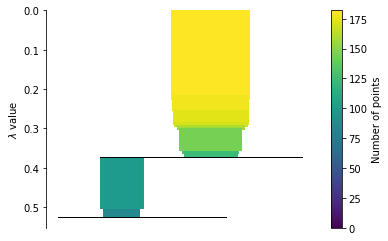

In [68]:
clusterer.condensed_tree_.plot()

<AxesSubplot:ylabel='distance'>

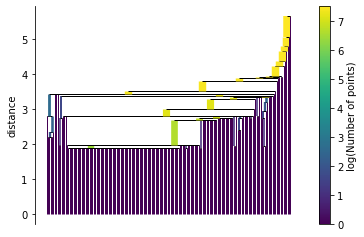

In [69]:
clusterer.single_linkage_tree_.plot()

In [70]:
projection = TSNE(metric='precomputed').fit_transform(distance_matrix)

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


In [71]:
plt.style.use('default')


In [72]:
(x,y) = projection.T[0], projection.T[1]

Text(0, 0.5, 'TSNE 2')

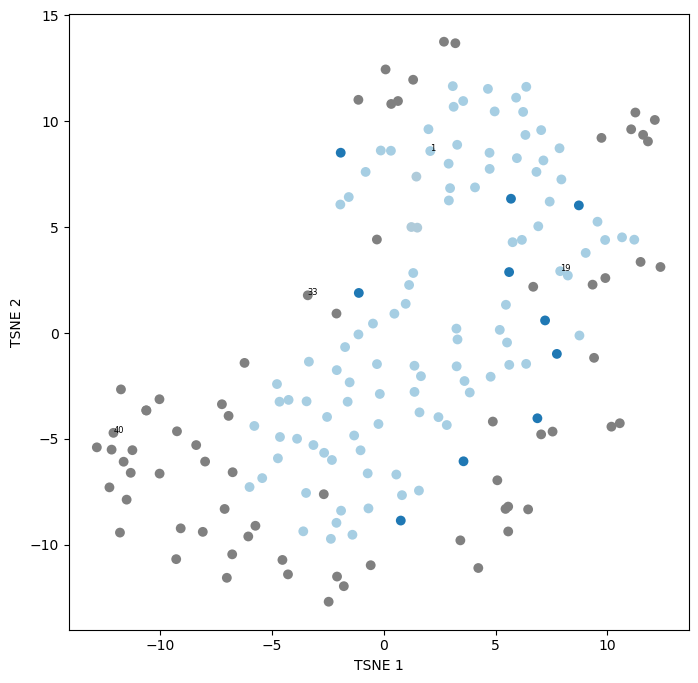

In [73]:
color_palette = sns.color_palette('Paired', np.max(clusterer.labels_)+1)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
fig, ax =plt.subplots(nrows=1, ncols=1, figsize=(8,8))
ax.scatter(*projection.T, s=50, linewidth=0, c=cluster_member_colors, alpha=1)
for i, txt in enumerate(idx):
    ax.annotate(str(txt), (x[i], y[i]), fontsize=6)
# plt.scatter(*projection.T, s=50, linewidth=0, c='k', alpha=0.25)
ax.set_xlabel('TSNE 1')
ax.set_ylabel('TSNE 2')

In [74]:
node_level = 16
node_num = 2864
fig = plot_node(isax_pipe, component, node_level=node_level, node_num=node_num)

NameError: name 'plot_node' is not defined

In [ ]:
node_level = 16
node_num = 1211
fig = plot_node(isax_pipe, node_level=node_level, node_num=node_num)

TypeError: plot_node() missing 1 required positional argument: 'ntimeseries'

In [ ]:
 #wandb_logger = WandbLogger(name=f'{args.data_type}_{args.arch}_{txt}', entity='solar-wind', project='main-experime', log_model='all',job_type='test')
   


In [ ]:
node_level = 16
node_num = 8
wandb.init(
    entity='solar-wind', 
    project='CB_hdbscan_week_5', 
    job_type='hdbscan_test',
    config=isax_pipe.input_parameters
    )
fig = plot_node(isax_pipe, node_level=node_level, node_num=node_num)
wandb.log({"plot": fig})
wandb.finish()
fig

wandb: wandb version 0.11.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


TypeError: plot_node() missing 1 required positional argument: 'ntimeseries'